In [25]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import json
from scipy.stats import weibull_min
import autograd.numpy as np
import pandas as pd
plt.style.use('seaborn')
%matplotlib inline

from lifelines import WeibullFitter, KaplanMeierFitter, ExponentialFitter, NelsonAalenFitter
from lifelines.fitters import ParametricUnivariateFitter
from lifelines.utils import restricted_mean_survival_time as rmst, qth_survival_time as qst
from scipy.stats import kstest, cramervonmises, uniform

#custom
from scripts.utils import *

In [14]:
data = json.load(open('data/data.json', 'r'))
data.keys()

dict_keys(['Curcumin control', 'Curcumin experiment', 'Berberine control', 'Berberine experiment', 'Sirtuin control', 'Sirtuin experiment', 'Rapamycin control', 'Rapamycin experiment', 'Keto control', 'Rapamycin2 control', 'Diet control', 'AKG control', 'Frailty control', 'Chinese control', 'Circad control'])

In [15]:
alter_names = ['- curcumin', '+ curcumin', '- berberine', '+ berberine', '- SIRT6', '+ SIRT6',
               '- rapamycin', '+ rapamycin', 'PMID: 28877458', 'PMID: 24409289', 'PMID: 28877457',
               'PMID: 32877690', 'PMID: 32934233', 'PMID: 20370440', 'PMID: 35511946']

In [16]:
#build descriptive statistics
df = pd.DataFrame(#{"Plausibility":plau}, 
                    index=alter_names)
df['n'] = [v['n'] for v in data.values()]

mst = []
m95 = []
m50 = []
m05 = []
for i, (name, experiment) in enumerate(data.items()):
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    kmf = KaplanMeierFitter().fit(T)

    mst.append(int(rmst(kmf, 1500)))
    m95.append(int(qst(0.95, kmf)))
    m50.append(int(qst(0.50, kmf)))
    m05.append(int(qst(0.05, kmf)))

df['Mean Surv Time'] = mst
df['5% Surv Time'] = m05
df['Median Surv Time'] = m50
df['95% Surv Time'] = m95

In [17]:
df

,n,Mean Surv Time,5% Surv Time,Median Surv Time,95% Surv Time
- curcumin,50,830,1033,823,580
+ curcumin,50,882,1033,882,640
- berberine,22,605,709,598,446
+ berberine,22,661,755,693,527
- SIRT6,52,753,1051,745,392
+ SIRT6,51,911,1105,937,647
- rapamycin,18,938,1234,927,679
+ rapamycin,17,1087,1401,1082,807
PMID: 28877458,61,879,1088,901,474
PMID: 24409289,40,815,1020,804,558


In [71]:
def compute_ds(sample, recording_times):
    bins = np.sort(np.unique(recording_times))
    freqs, bins = np.histogram(sample, bins)
    dS = freqs / np.diff(bins)
    return dS
    
def overmortality_permutation_test(x, y, n, T, m=1000):
    T = convert_to_lifetimes(x, y, n) 
    n_steps = np.unique(T).shape[0]
    dS = compute_ds(T, T)[:-1]
    N = len(T)

    #Fit models to the sample
    wf = WeibullFitter().fit(T)
    l, k = wf.lambda_, wf.rho_

    ggf = GompertzFitter(T).fit(T)
    A, B = ggf.nu_, ggf.b_

    #overmortality_test
    tw, tg = 0, 0
    for _ in range(m):
        #draw samples from the target models
        wsample = l * np.random.weibull(k, N)
        gsample = generate_gompertz_sample(A, B, np.max(T), n=N)
        #compute their derivatives
        dSw = compute_ds(wsample, T)
        dSg = compute_ds(gsample, T)
        
        if dS.max() > dSw.max():
            tw += 1
        if dS.max() > dSg.max():
            tg += 1
    wpval = 1 - tw/m
    gpval = 1 - tg/m
    # print(wpval, gpval)
    geom_mean = np.sqrt(wpval * gpval)
    return geom_mean

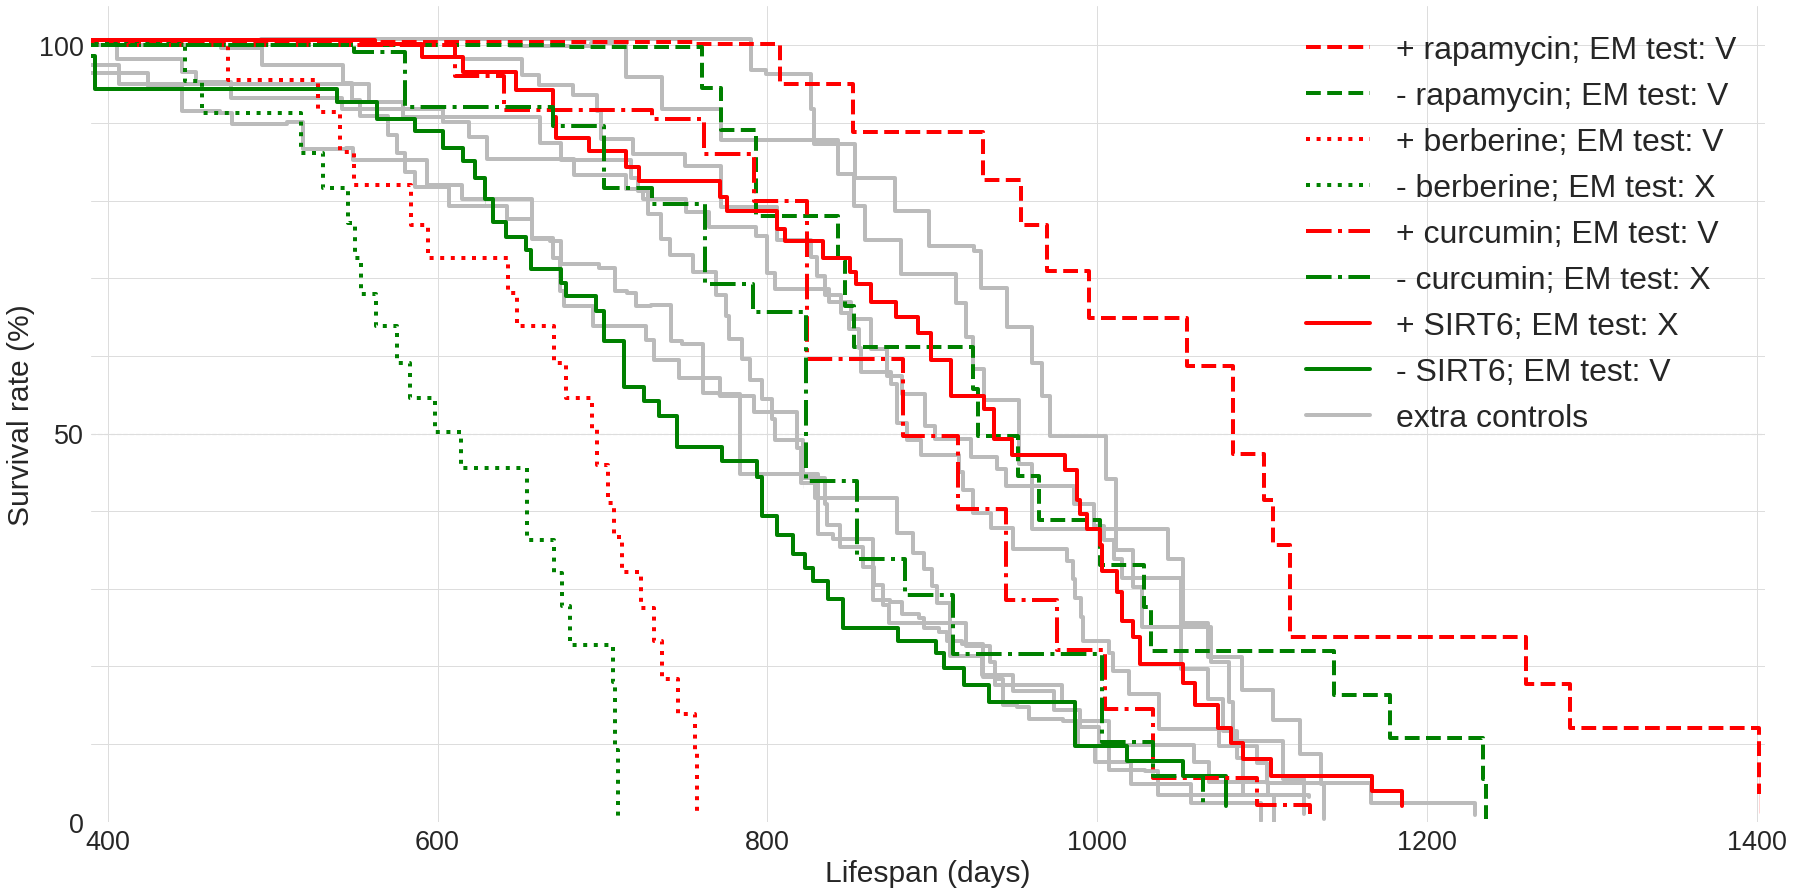

In [83]:
plt.style.use('seaborn')
def prepare_plot(title='Title'):
  fig, ax = plt.subplots(figsize=(30,15))
  #sns.set(font_scale=1.3, rc={'axes.facecolor':'w', 'figure.facecolor':'#eee'}) #, rc={'axes.facecolor':'#eee'}, 'figure.facecolor':'cornflowerblue'
  sns.set_style("whitegrid")
  sns.set_context("paper", font_scale=3.1)
  ax.axhline(50, ls='--', color='#ddd')
  ax.set_title(title, fontsize=21, y=1.05)
  ax.set_xlabel("Lifespan (days)",fontsize=30)
  ax.set_ylabel("Survival rate (%)",fontsize=30)
  return fig, ax

def prepare_data(data):
  data = data.splitlines()
  return np.array(data, dtype=float)

def overmortality_pipe(experiment, alpha=0.01):
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    pval = overmortality_permutation_test(x, y, n, T, 1000)
    verdict = 'V' if pval > alpha else 'X'
    return verdict

    
# with sns.axes_style("whitegrid"):
with sns.axes_style("whitegrid", {"grid.color" : "#ddd"}):
  fig, ax = prepare_plot(title='')
  ax.margins(y=-0.004)
  plt.xlim([390, 1405])
  plt.ylim(bottom=90, top=105)
  ax.set_yticks(range(0, 101, 10))
  ax.tick_params(axis='both', which='major', labelsize=27)

  for i in range(4):
    ax.yaxis.get_ticklabels()[1].set_visible(False)
  for i in range(4):
    ax.yaxis.get_ticklabels()[2].set_visible(False)

  
  ax = sns.lineplot(data=data['Keto control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)         # + label= 'control n=61 PMID: 28877458'
  ax3 = sns.lineplot(data=data['Diet control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)         # + , label= 'control n=43 PMID: 28877457'
  ax4 = sns.lineplot(data=data['Frailty control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)       # , label= 'control n=24 PMID: 32934233'
  ax5 = sns.lineplot(data=data['AKG control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)                   # , label= 'control n=24 PMID: 32877690'
  ax6 = sns.lineplot(data=data['Rapamycin2 control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)        # , label= 'control n=40 PMID: 24409289'
  ax7 = sns.lineplot(data=data['Circad control'], y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)                # + , label= 'control n=43 PMID: 35511946'
  ax8 = sns.lineplot(data=data['Chinese control'], y='y', x='x', color='#bbb', label= 'extra controls', drawstyle='steps-post', linewidth = 4)               # + control n=54 PMID: 20370440

  p = overmortality_pipe(data['Rapamycin experiment'])
  ax1= sns.lineplot(data=data['Rapamycin experiment'], y='y', x='x', color='r', 
                    label= '+ rapamycin' + f'; EM test: {p}', ls='--', drawstyle='steps-post', linewidth = 4)                         # + 8 mg/kg/day i.p. rapamycin n=17
  
  p = overmortality_pipe(data['Rapamycin control'])                    
  ax0= sns.lineplot(data=data['Rapamycin control'], y='y', x='x', color='g', 
                    label= '- rapamycin' + f'; EM test: {p}', drawstyle='steps-post', ls='--', linewidth = 4)                   # + control n=18
  
  p = overmortality_pipe(data['Berberine experiment'])
  ax21= sns.lineplot(data=data['Berberine experiment'], y='y', x='x', color='r', 
                    label= '+ berberine' + f'; EM test: {p}', ls=':', drawstyle='steps-post', linewidth = 4, ci=95)  # + 50 mg/kg Berberine n=22
  
  p = overmortality_pipe(data['Berberine control'])
  ax20= sns.lineplot(data=data['Berberine control'], y='y', x='x', color='g', 
                    label= '- berberine' + f'; EM test: {p}', drawstyle='steps-post', ls=':', linewidth = 4)                         # +  control n=22
  
  p = overmortality_pipe(data['Sirtuin experiment'])
  ax11= sns.lineplot(data=data['Sirtuin experiment'], y='y', x='x', color='r', 
                    label= '+ SIRT6' + f'; EM test: {p}', drawstyle='steps-post', linewidth = 4)                    # + SIRT6 overexpression n=51
  
  p = overmortality_pipe(data['Sirtuin control'])
  ax10= sns.lineplot(data=data['Sirtuin control'], y='y', x='x', color='g', 
                    label= '- SIRT6' + f'; EM test: {p}', drawstyle='steps-post', linewidth = 4)                               # + SIRT6 control n=52
  
  p = overmortality_pipe(data['Curcumin experiment'])
  ax12= sns.lineplot(data=data['Curcumin experiment'], y='y', x='x', color='r', ls='-.', 
                    label= '+ curcumin' + f'; EM test: {p}', drawstyle='steps-post', linewidth = 4)                    # + SIRT6 overexpression n=51
  
  p = overmortality_pipe(data['Curcumin control'])
  ax13= sns.lineplot(data=data['Curcumin control'], y='y', x='x', color='g', ls='-.', 
                    label= '- curcumin' + f'; EM test: {p}', drawstyle='steps-post', linewidth = 4)                               # + SIRT6 control n=52

  # plt.legend(loc='lower left')
  handles, labels = ax.get_legend_handles_labels()
  # print(labels)
  order = [1, 2, 3, 4, 7, 8, 5, 6, 0]
  plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=32)

  # plt.savefig('line_plot.pdf', dpi=300)  


# спасибо .. замечания по картинке. 
# + 1. наверное не надо на главной картинке помечать контроли отдельно, не о них речь идет. 
#     Давайте сделаем две картинки, одну в Supplement где отрисованы "серые контроли контролей" каждый своим цветом или штрихом и помечены PMID. 
# +   А в Этой главной и единственой картинке пометим все их серым одинаково.  Серы если можно потемнее ...  и просто обзовем их "extra control" пока. 
# + 2. не надо начинать Lifespan с Нуля. мертвое пространство на графике. можно где то с 500 (?) дней. 
# + 3. по оси Y сличком много меток и мелковато, важно чтоб был 100%,  50%  и 0%. 
# + 4. количество мышей можно тоже оставить для подписи к картинке, легенду хочу сделать короткую и крупно хорошо видную.  
# 5.  как то я не обращал внимание раньше на ступенку в Рапамицине, и в контролях и в красной ... у нас по этим мышам только одна статья с рапомицином ? как то мало там зверей ... 17 + 18.   Ну если нет больше будем с этими двигаться. 
# + 6. дозу тоже можно оставить для подписи и убрать из легенды.   Может  все что надо в легенде это " + SIRT6, - SIRT6, + barb, - barb, + rapa, - rapa, extras"

# Meta control


Median surv time = 864.10597


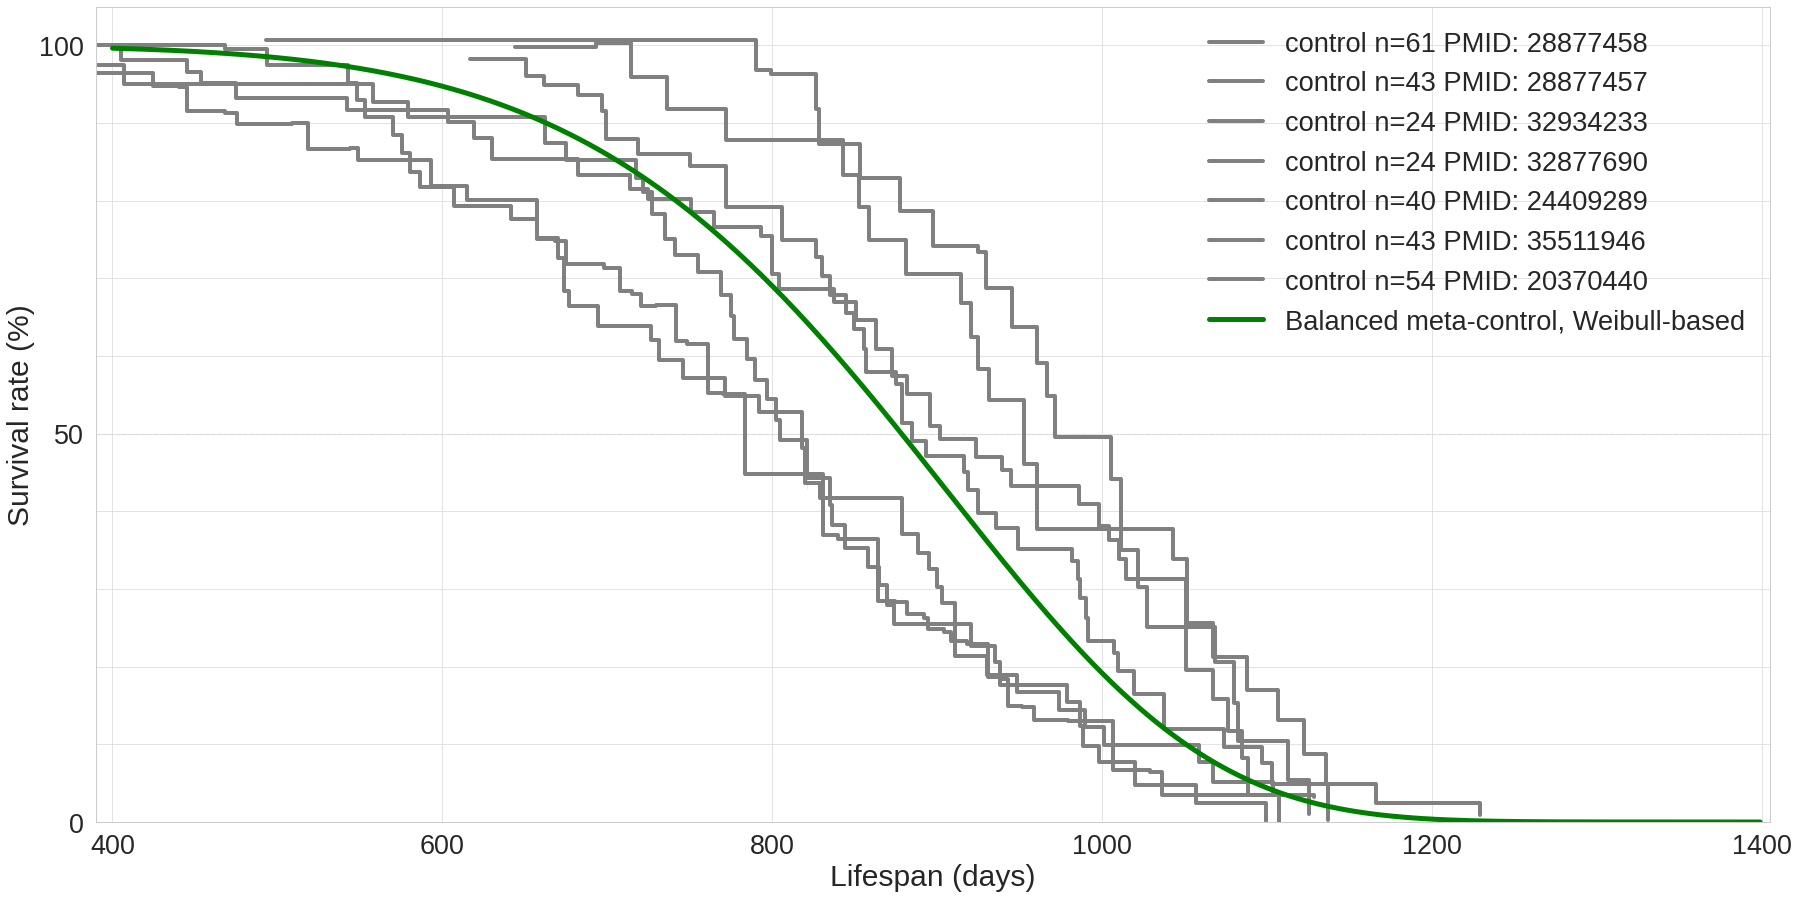

In [81]:
controls = [
            #'Curcumin control',
            # 'Berberine control',
            # 'Sirtuin control',
            # 'Rapamycin control',
            'Keto control',
            'Rapamycin2 control',
            'Diet control',
            'AKG control',
            'Frailty control',
            'Chinese control',
            'Circad control'
            ]

coef_stat = pd.DataFrame(columns=['name', 'lmb', 'rho', 'lmb_V', 'rho_V', 'EM_pval'])
times_sep = []
times = []
for i, (name, experiment) in enumerate(data.items()):
    if name not in controls:
        continue
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    
    pval = overmortality_permutation_test(x, y, n, T, 1000)
    times += T
    times_sep.append(T)

    wf = WeibullFitter().fit(T)
    lmb, rho = wf.summary.iloc[0, 0], wf.summary.iloc[1, 0]
    lmb_se, rho_se = wf.summary.iloc[0, 1], wf.summary.iloc[1, 1]
    coef_stat = coef_stat.append({'name':name, 'lmb':lmb, 'rho':rho, 'lmb_V':lmb_se**2, 'rho_V':rho_se**2, 'EM_pval':pval},
                                ignore_index=True)
coef_stat = coef_stat.set_index('name')

km = KaplanMeierFitter().fit(times,)
table = km.event_table
table = table.reset_index()
table['y'] = table['at_risk'] / table['at_risk'].iloc[0] * 100

print('Median surv time =', km.median_survival_time_)

# with sns.axes_style("whitegrid"):
with sns.axes_style("whitegrid", {"grid.color" : "#ddd"}):
    fig, ax = prepare_plot(title='')
    ax.margins(y=-0.004)
    plt.xlim([390, 1405])
    plt.ylim(bottom=90, top=105)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.tick_params(axis='both', which='major', labelsize=27)

    for i in np.arange(4):
        ax.yaxis.get_ticklabels()[1].set_visible(False)
    for i in np.arange(4):
        ax.yaxis.get_ticklabels()[2].set_visible(False)
    
    mcolor = '#F5B041'
    ccolor = 'grey'
    ax = sns.lineplot(data=data['Keto control'], y='y', x='x', color=ccolor, label= 'control n=61 PMID: 28877458', drawstyle='steps-post', linewidth = 4)         # +
    ax3 = sns.lineplot(data=data['Diet control'], y='y', x='x', color=ccolor, label= 'control n=43 PMID: 28877457', drawstyle='steps-post', linewidth = 4)         # +
    ax4 = sns.lineplot(data=data['Frailty control'], y='y', x='x', color=ccolor, label= 'control n=24 PMID: 32934233', drawstyle='steps-post', linewidth = 4)       # 
    ax5 = sns.lineplot(data=data['AKG control'], y='y', x='x', color=ccolor, label= 'control n=24 PMID: 32877690', drawstyle='steps-post', linewidth = 4)                   # 
    ax6 = sns.lineplot(data=data['Rapamycin2 control'], y='y', x='x', color=ccolor, label= 'control n=40 PMID: 24409289', drawstyle='steps-post', linewidth = 4)        # 
    ax7 = sns.lineplot(data=data['Circad control'], y='y', x='x', color=ccolor, label= 'control n=43 PMID: 35511946', drawstyle='steps-post', linewidth = 4)                # +
    ax8 = sns.lineplot(data=data['Chinese control'], y='y', x='x', color=ccolor, label= 'control n=54 PMID: 20370440', drawstyle='steps-post', linewidth = 4)               # +

    ### NAIVE ESTIMATOR ###
    # sns.lineplot(data=table, x='event_at', y='y', color=mcolor, label=f'Meta control naive, {len(controls)} studies', drawstyle='steps-post', linewidth = 6)
    
    ### META REGRESSION ###
    from pymare import meta_regression
    lmb_mres = meta_regression(coef_stat['lmb'], coef_stat['lmb_V'])
    rho_mres = meta_regression(coef_stat['rho'], coef_stat['rho_V'])

    l, k = lmb_mres.to_df()['estimate'].item(), rho_mres.to_df()['estimate'].item()
    target_cdf = lambda x: 1 - np.exp(-(x / l)**k)
    x_wf = np.arange(400, 1400)

    sns.lineplot(x_wf, (1 - target_cdf(x_wf)) * 100, lw=5, label='Balanced meta-control, Weibull-based', color='g')
    

# спасибо .. замечания по картинке. 
# + 1. наверное не надо на главной картинке помечать контроли отдельно, не о них речь идет. 
# +    Давайте сделаем две картинки, одну в Supplement где отрисованы "серые контроли контролей" каждый своим цветом или штрихом и помечены PMID. 
# +    А в Этой главной и единственой картинке пометим все их серым одинаково.  Серы если можно потемнее ...  и просто обзовем их "extra control" пока. 
# + 2. не надо начинать Lifespan с Нуля. мертвое пространство на графике. можно где то с 500 (?) дней. 
# 3. по оси Y сличком много меток и мелковато, важно чтоб был 100%,  50%  и 0%. 
# 4. количество мышей можно тоже оставить для подписи к картинке, легенду хочу сделать короткую и крупно хорошо видную.  
# 5.  как то я не обращал внимание раньше на ступенку в Рапамицине, и в контролях и в красной ... у нас по этим мышам только одна статья с рапомицином ? как то мало там зверей ... 17 + 18.   Ну если нет больше будем с этими двигаться. 
# 6. дозу тоже можно оставить для подписи и убрать из легенды.   Может  все что надо в легенде это " + SIRT6, - SIRT6, + barb, - barb, + rapa, - rapa, extras"

In [82]:
coef_stat

,lmb,rho,lmb_V,rho_V,EM_pval
name,,,,,
Keto control,950.092506,6.225108,437.576767,0.482874,0.054222
Rapamycin2 control,870.038289,7.181494,417.252057,0.799929,0.016523
Diet control,961.552303,7.208850,474.940178,0.683761,0.232991
AKG control,1012.227949,11.840560,339.195750,3.665002,0.043875
Frailty control,1000.695425,8.486069,619.090959,1.833783,0.094995
Chinese control,834.854490,5.532559,482.862529,0.385021,0.597408
Circad control,863.088040,5.419356,674.633528,0.424057,0.009798


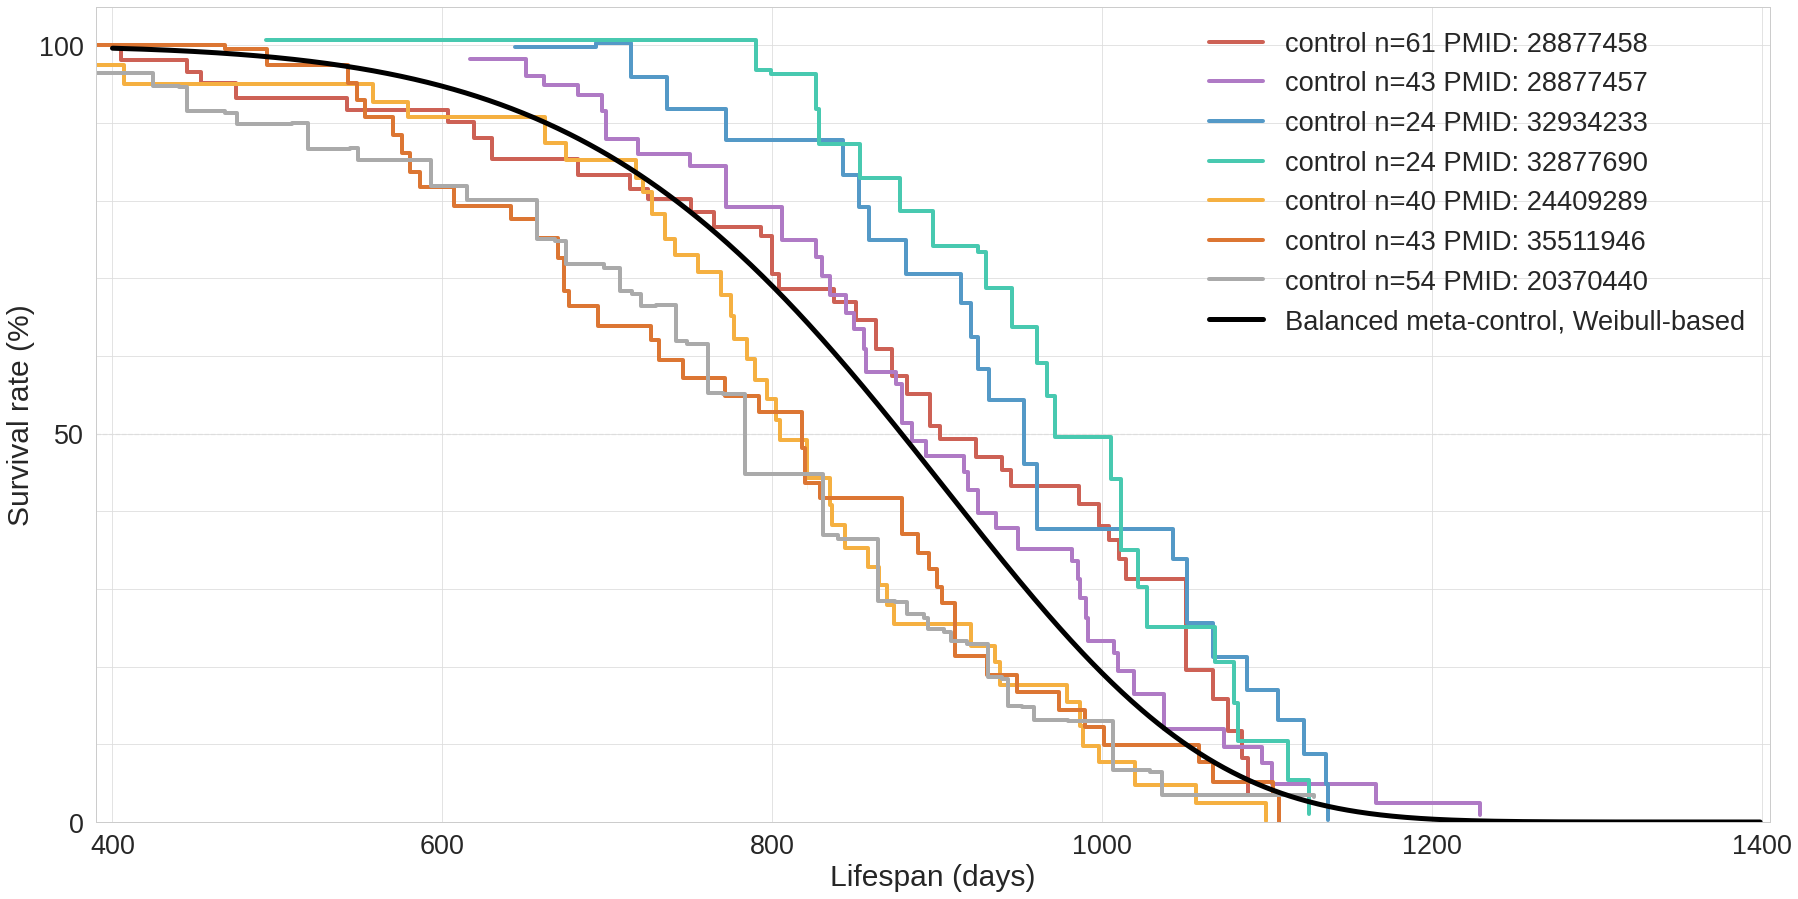

In [84]:
# with sns.axes_style("whitegrid"):
with sns.axes_style("whitegrid", {"grid.color" : "#ddd"}):
  fig, ax = prepare_plot(title='')
  ax.margins(y=-0.004)
  plt.xlim([390, 1405])
  plt.ylim(bottom=90, top=105)
  ax.set_yticks(range(0, 101, 10))
  ax.tick_params(axis='both', which='major', labelsize=27)

  for i in range(4):
    ax.yaxis.get_ticklabels()[1].set_visible(False)
  for i in range(4):
    ax.yaxis.get_ticklabels()[2].set_visible(False)

  ax = sns.lineplot(data=data['Keto control'], y='y', x='x', color='#CD6155', label= 'control n=61 PMID: 28877458', drawstyle='steps-post', linewidth = 4)         # +
  ax3 = sns.lineplot(data=data['Diet control'], y='y', x='x', color='#AF7AC5', label= 'control n=43 PMID: 28877457', drawstyle='steps-post', linewidth = 4)         # +
  ax4 = sns.lineplot(data=data['Frailty control'], y='y', x='x', color='#5499C7', label= 'control n=24 PMID: 32934233', drawstyle='steps-post', linewidth = 4)       # 
  ax5 = sns.lineplot(data=data['AKG control'], y='y', x='x', color='#48C9B0', label= 'control n=24 PMID: 32877690', drawstyle='steps-post', linewidth = 4)                   # 
  ax6 = sns.lineplot(data=data['Rapamycin2 control'], y='y', x='x', color='#F5B041', label= 'control n=40 PMID: 24409289', drawstyle='steps-post', linewidth = 4)        # 
  ax7 = sns.lineplot(data=data['Circad control'], y='y', x='x', color='#DC7633', label= 'control n=43 PMID: 35511946', drawstyle='steps-post', linewidth = 4)                # +
  ax8 = sns.lineplot(data=data['Chinese control'], y='y', x='x', color='#aaa', label= 'control n=54 PMID: 20370440', drawstyle='steps-post', linewidth = 4)               # +

  ### META REGRESSION ###
  from pymare import meta_regression
  lmb_mres = meta_regression(coef_stat['lmb'], coef_stat['lmb_V'])
  rho_mres = meta_regression(coef_stat['rho'], coef_stat['rho_V'])

  l, k = lmb_mres.to_df()['estimate'].item(), rho_mres.to_df()['estimate'].item()
  target_cdf = lambda x: 1 - np.exp(-(x / l)**k)
  x_wf = np.arange(400, 1400)

  sns.lineplot(x_wf, (1 - target_cdf(x_wf)) * 100, lw=5, label='Balanced meta-control, Weibull-based', color='black')
# спасибо .. замечания по картинке. 
# + 1. наверное не надо на главной картинке помечать контроли отдельно, не о них речь идет. 
# +    Давайте сделаем две картинки, одну в Supplement где отрисованы "серые контроли контролей" каждый своим цветом или штрихом и помечены PMID. 
# +    А в Этой главной и единственой картинке пометим все их серым одинаково.  Серы если можно потемнее ...  и просто обзовем их "extra control" пока. 
# + 2. не надо начинать Lifespan с Нуля. мертвое пространство на графике. можно где то с 500 (?) дней. 
# 3. по оси Y сличком много меток и мелковато, важно чтоб был 100%,  50%  и 0%. 
# 4. количество мышей можно тоже оставить для подписи к картинке, легенду хочу сделать короткую и крупно хорошо видную.  
# 5.  как то я не обращал внимание раньше на ступенку в Рапамицине, и в контролях и в красной ... у нас по этим мышам только одна статья с рапомицином ? как то мало там зверей ... 17 + 18.   Ну если нет больше будем с этими двигаться. 
# 6. дозу тоже можно оставить для подписи и убрать из легенды.   Может  все что надо в легенде это " + SIRT6, - SIRT6, + barb, - barb, + rapa, - rapa, extras"

In [29]:
coef_stat.to_csv('data/coef_stat.csv')

In [23]:
rho_mres.to_df()

,name,estimate,se,z-score,p-value,ci_0.025,ci_0.975
0,intercept,6.518376,0.373338,17.459711,0.0,5.786647,7.250105


In [24]:
lmb_mres.to_df()

,name,estimate,se,z-score,p-value,ci_0.025,ci_0.975
0,intercept,919.109836,22.813684,40.287656,0.0,874.395837,963.823834
